# Table of Contents
1. [Exploring How Optimized Models Deal With the Different Preprocessors](#Exploring-How-Optimized-Models-Deal-With-the-Different-Preprocessors)
2. [Exploring the Impact of Transection Rate](#Exploring-the-Impact-of-Transection-Rate)
3. [Graphs for the README.md](#Graphs-for-the-README.md)

# Exploring How Optimized Models Deal With the Different Preprocessors

In [2]:
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import seaborn as sns
import xgboost

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import average_precision_score

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV, 
    PredefinedSplit,
)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
)

from xgboost import plot_importance

from src.config import (
    CLEAN_DATA,
    DATA_FOLDER,
    RANDOM_STATE,
    PREPROCESSOR_FIG,
    HP_OPTIMIZATION_FIG,
)

from src.models import (
    grid_search_cv_model,
)

sns.set_theme(style='dark', palette='colorblind', context='notebook')

### Code require to run the analyses

In [5]:
df = pd.read_parquet(CLEAN_DATA)

feature_dict = {
    'category': ['Transaction_rate'],
    'numeric': list(df.columns[~df.columns.isin(['Time','Class','Transaction_rate'])]),
    'time': ['Time'],
    'target': ['Class'],
}

X = df.drop(columns=feature_dict['target'] + feature_dict['time'])
y = df[feature_dict['target']].to_numpy().ravel()

# Split the data into train and test based on temporal order (one day train and one day test)
split_time_threshold = 86400  # Define the time threshold
train_indices = df[df['Time'] <= split_time_threshold].index

# Define the split for GridSearchCV
test_fold = [-1 if i in train_indices else 0 for i in range(len(df))]
custom_split = PredefinedSplit(test_fold)

preprocessor_dict = {
    'one_hot_encoder': feature_dict['category'],
    'power_transformer': [item for item in feature_dict['numeric'] if item not in ['V13','V15','V19','V24','V26']],
    'quantile_transformer': [item for item in feature_dict['numeric'] if item not in ['V13','V15','V19','V24','V26']],    
}

preprocessor_ohe_robust_amount = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), preprocessor_dict['one_hot_encoder']),
        ("robust", RobustScaler(), ['Amount']),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False,
    
)

preprocessor_ohe_power = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), preprocessor_dict['one_hot_encoder']),
        ("power_transformer", PowerTransformer(), preprocessor_dict['power_transformer']),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False,
    
)

preprocessor_ohe_quantile = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), preprocessor_dict['one_hot_encoder']),
        ("quantile_transformer", QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE), preprocessor_dict['quantile_transformer']),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False,
    
)

param_grid = {
    "preprocessor": [preprocessor_ohe_robust_amount, preprocessor_ohe_quantile, preprocessor_ohe_power],    
}

X_train = X.iloc[train_indices]
y_train = y[train_indices]

## Logistic Regression

In [7]:
study_name = str(DATA_FOLDER/"logistic_regression_round1")
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
best_trial = study.best_trial
best_params = best_trial.params

[I 2025-01-31 09:49:58,984] Using an existing study with name '/home/alexhubbe/MEGA/data_science/portfolio/fraud_project/data/logistic_regression_round1' instead of creating a new one.


In [10]:
# Run grid search using the best hyperparameters from the Optuna study
grid_search = grid_search_cv_model(
    model=LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **best_params  # Pass the best hyperparameters dynamically
    ),
    preprocessor=preprocessor_ohe_power,
    target_transformer=None,
    param_grid=param_grid,
    cv=custom_split,
    scoring='average_precision'
)

grid_search.fit(X, y)

df_scores_gridsearchcv = pd.DataFrame(grid_search.cv_results_)

df_scores = df_scores_gridsearchcv[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

df_scores.rename(columns={
    'params': 'Preprocessor Applied',
    'mean_test_score': 'Average Precision'
}, inplace=True)

df_scores.loc[0,'Preprocessor Applied'] = 'OneHotEncoder and RobustScaler on Amount'
df_scores.loc[1,'Preprocessor Applied'] = 'OneHotEncoder and QuantileTransformer'
df_scores.loc[2,'Preprocessor Applied'] = 'OneHotEncoder and PowerTransformer'

df_scores

Fitting 1 folds for each of 3 candidates, totalling 3 fits


,Preprocessor Applied,Average Precision
1,OneHotEncoder and QuantileTransformer,0.812789
2,OneHotEncoder and PowerTransformer,0.736767
0,OneHotEncoder and RobustScaler on Amount,0.665335


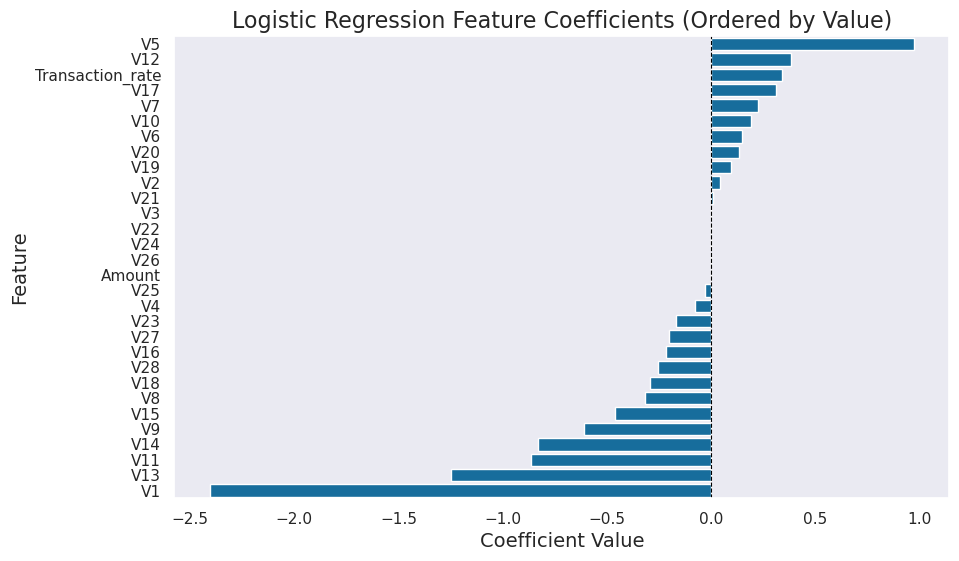

In [12]:
# Define preprocessor and model
preprocessor = preprocessor_ohe_quantile

model = LogisticRegression(
    random_state=RANDOM_STATE,
    penalty='elasticnet',
    solver='saga',
    max_iter=1_000,
    n_jobs=-1,
    **best_params  # Pass the best hyperparameters dynamically
)

# Create pipeline
pipeline_model = Pipeline([("preprocessor", preprocessor), ("model", model)])

# Fit the pipeline with the training data
pipeline_model.fit(X_train, y_train)

# Extract the trained Logistic Regression model from the pipeline
fitted_model = pipeline_model.named_steps["model"]

# Extract feature coefficients
coefficients = fitted_model.coef_[0]  # Use `coef_[0]` for binary classification

# Create a DataFrame for feature coefficients
feature_names = X_train.columns  # Ensure X_train is a DataFrame to access column names
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort coefficients by actual values (from most positive to most negative)
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_coefficients,
    x='Coefficient',
    y='Feature',
    order=feature_coefficients['Feature'],  # Use sorted feature names by coefficient
    )

# Add title and labels
plt.title('Logistic Regression Feature Coefficients (Ordered by Value)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Add vertical reference line at 0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

## XGBoost

In [14]:
study_name = str(DATA_FOLDER/"xgboost_round2")
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
best_trial = study.best_trial
best_params = best_trial.params

[I 2025-01-31 09:57:20,326] Using an existing study with name '/home/alexhubbe/MEGA/data_science/portfolio/fraud_project/data/xgboost_round2' instead of creating a new one.


In [15]:
# Run grid search using the best hyperparameters from the Optuna study
grid_search = grid_search_cv_model(
    model=xgboost.XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **best_params  # Pass the best hyperparameters dynamically
    ),
    preprocessor=preprocessor_ohe_power,
    target_transformer=None,
    param_grid=param_grid,
    cv=custom_split,
    scoring='average_precision'
)

grid_search.fit(X, y)

df_scores_gridsearchcv = pd.DataFrame(grid_search.cv_results_)

df_scores = df_scores_gridsearchcv[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

df_scores.rename(columns={
    'params': 'Preprocessor Applied',
    'mean_test_score': 'Average Precision'
}, inplace=True)

df_scores.loc[0,'Preprocessor Applied'] = 'OneHotEncoder and RobustScaler on Amount'
df_scores.loc[1,'Preprocessor Applied'] = 'OneHotEncoder and QuantileTransformer'
df_scores.loc[2,'Preprocessor Applied'] = 'OneHotEncoder and PowerTransformer'

df_scores

Fitting 1 folds for each of 3 candidates, totalling 3 fits


,Preprocessor Applied,Average Precision
1,OneHotEncoder and QuantileTransformer,0.801961
0,OneHotEncoder and RobustScaler on Amount,0.797746
2,OneHotEncoder and PowerTransformer,0.797233


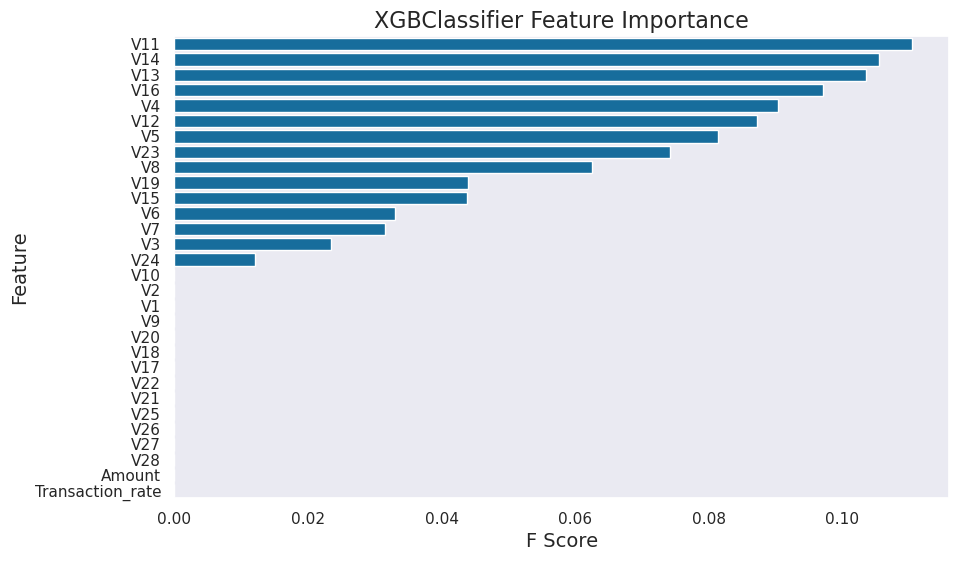

In [16]:
preprocessor = preprocessor_ohe_quantile

model=xgboost.XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **best_params  # Pass the best hyperparameters dynamically
    )

pipeline_model = Pipeline([("preprocessor", preprocessor), ("model", model)])

pipeline_model.fit(X_train,y_train)
# Extract the trained XGBClassifier from the pipeline
fitted_model = pipeline_model.named_steps["model"]

# Extract feature importances
importances = fitted_model.feature_importances_

# Create a DataFrame for better handling
feature_names = X_train.columns  # Ensure X_train is a DataFrame to get column names
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importances,
    x='Importance',
    y='Feature',
)

plt.title('XGBClassifier Feature Importance', fontsize=16)
plt.xlabel('F Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()


## Random Forest

In [18]:
study_name = str(DATA_FOLDER/"random_forest_round2")
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
best_trial = study.best_trial
best_params = best_trial.params

[I 2025-01-31 09:57:30,933] Using an existing study with name '/home/alexhubbe/MEGA/data_science/portfolio/fraud_project/data/random_forest_round2' instead of creating a new one.


In [19]:
# Run grid search using the best hyperparameters from the Optuna study
grid_search = grid_search_cv_model(
    model=RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **best_params  # Pass the best hyperparameters dynamically
    ),
    preprocessor=preprocessor_ohe_power,
    target_transformer=None,
    param_grid=param_grid,
    cv=custom_split,
    scoring='average_precision'
)

grid_search.fit(X, y)

df_scores_gridsearchcv = pd.DataFrame(grid_search.cv_results_)

df_scores = df_scores_gridsearchcv[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

df_scores.rename(columns={
    'params': 'Preprocessor Applied',
    'mean_test_score': 'Average Precision'
}, inplace=True)

df_scores.loc[0,'Preprocessor Applied'] = 'OneHotEncoder and RobustScaler on Amount'
df_scores.loc[1,'Preprocessor Applied'] = 'OneHotEncoder and QuantileTransformer'
df_scores.loc[2,'Preprocessor Applied'] = 'OneHotEncoder and PowerTransformer'

df_scores

Fitting 1 folds for each of 3 candidates, totalling 3 fits


,Preprocessor Applied,Average Precision
0,OneHotEncoder and RobustScaler on Amount,0.784263
2,OneHotEncoder and PowerTransformer,0.783115
1,OneHotEncoder and QuantileTransformer,0.782598


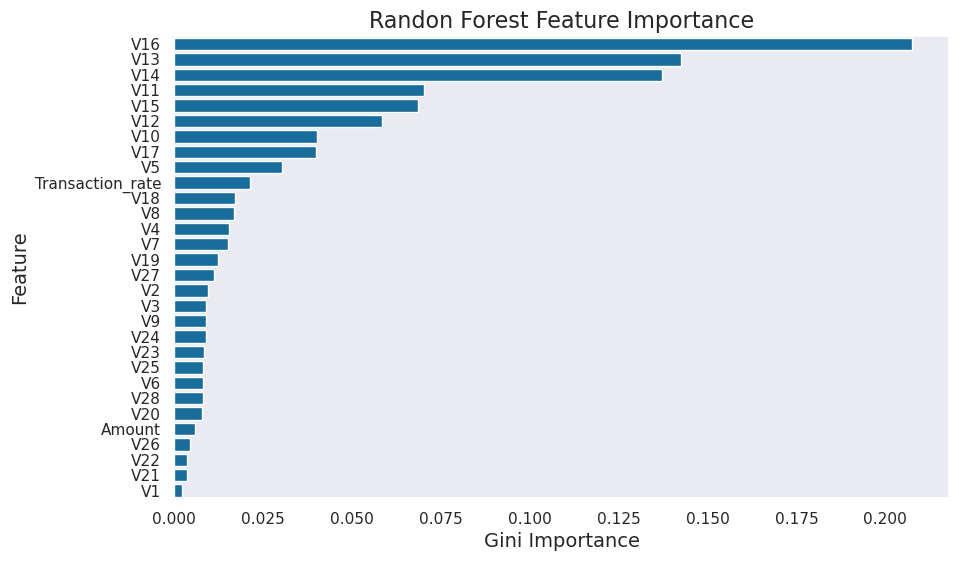

In [20]:
preprocessor = preprocessor_ohe_quantile

model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    **best_params  # Pass the best hyperparameters dynamically
)

pipeline_model = Pipeline([("preprocessor", preprocessor), ("model", model)])

pipeline_model.fit(X_train,y_train)
# Extract the trained XGBClassifier from the pipeline
fitted_model = pipeline_model.named_steps["model"]

# Extract feature importances
importances = fitted_model.feature_importances_

# Create a DataFrame for better handling
feature_names = X_train.columns  # Ensure X_train is a DataFrame to get column names
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importances,
    x='Importance',
    y='Feature',
)

plt.title('Randon Forest Feature Importance', fontsize=16)
plt.xlabel('Gini Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()


# Exploring the Impact of `Transection Rate`

I will conduct the analysis using only Logit, as it was the approach that resulted in the best score.

In [49]:
preprocessor_quantile = ColumnTransformer(
    transformers=[
        ("quantile_transformer", QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE), preprocessor_dict['quantile_transformer']),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False,
    
)

model = LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

# Create pipeline
pipeline_model = Pipeline([("preprocessor", preprocessor_quantile), ("model", model)])

score = cross_val_score(pipeline_model, X.drop('Transaction_rate',axis=1), y, n_jobs=-1, cv=custom_split, scoring='average_precision').mean()
print(f"The score including the feature is: 0.803806 \nThe score excluding the feature is: {round(score,6)}")

The score including the feature is: 0.803806 
The score excluding the feature is: 0.798459


# Graphs for the README.md

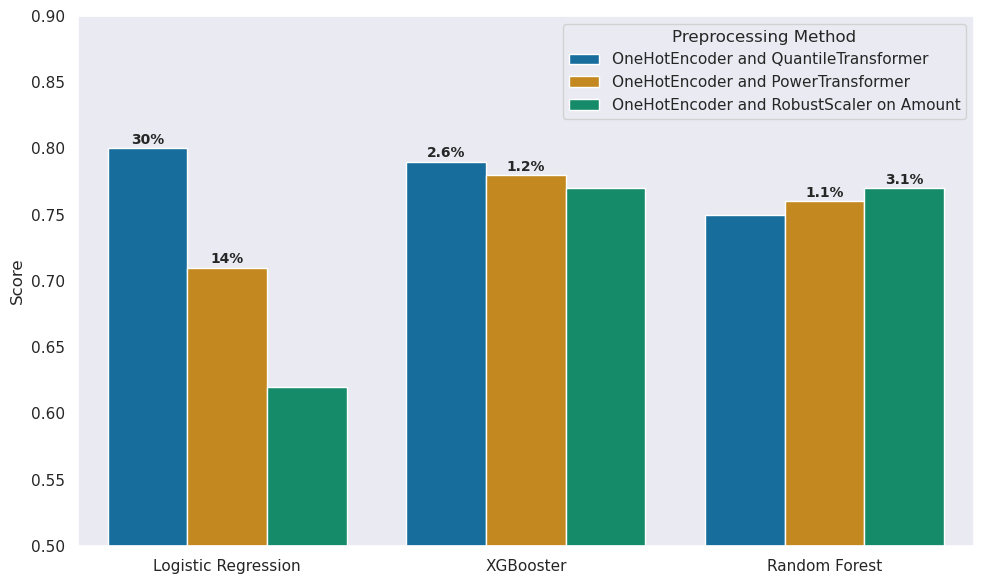

In [4]:
# Data
data = {
    "Method": [
        "Logistic Regression",
        "XGBooster",
        "Random Forest"
    ],
    "OneHotEncoder and QuantileTransformer": [0.80, 0.79, 0.75],
    "OneHotEncoder and PowerTransformer": [0.71, 0.78, 0.76],
    "OneHotEncoder and RobustScaler on Amount": [0.62, 0.77, 0.77]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to long format for Seaborn
df_long = df.melt(id_vars="Method", var_name="Preprocessor", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, x="Method", y="Score", hue="Preprocessor", width=0.8)

# Adjust y-axis scale
ax.set_ylim(0.5, 0.9)

# Define annotations for specific bars
annotations = {
    0: "30%",  1: "2.6%",  
    3: "14%", 4: "1.2%",   
    5: "1.1%", 8: "3.1%"  
}

# Add text annotations to specific bars
for i, bar in enumerate(ax.patches):
    if i in annotations:
        ax.text(bar.get_x() + bar.get_width()/2,  # X position (centered on bar)
                bar.get_height() + 0.001,          # Y position (above bar)
                annotations[i],                   # Annotation text
                ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

# Formatting
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(ha="center")  # Ensure labels are centered
plt.legend(title="Preprocessing Method")

#save plot
plt.savefig(PREPROCESSOR_FIG,dpi=150)

# Show plot
plt.tight_layout()
plt.show()


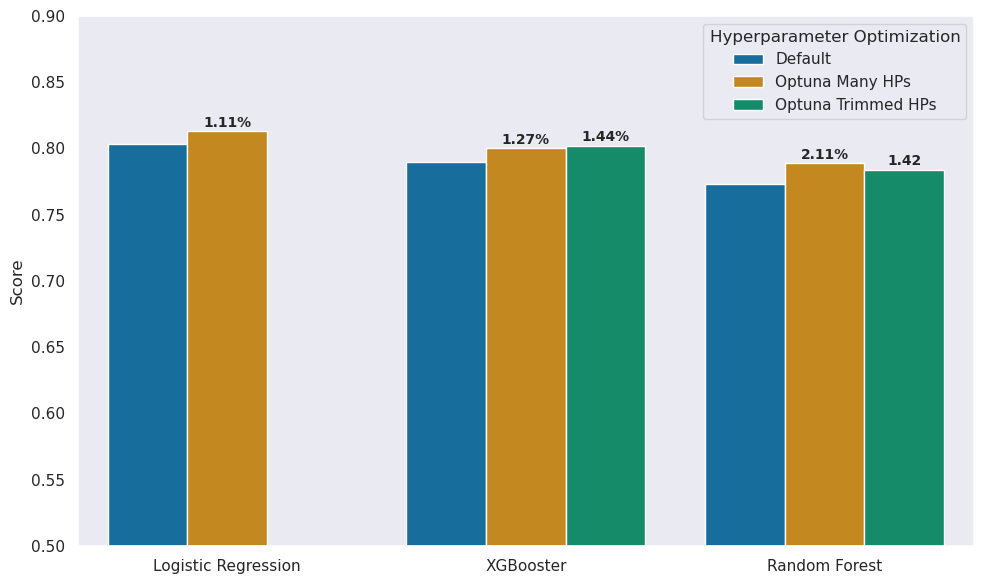

In [17]:
# Data
data = {
    "Method": [
        "Logistic Regression",
        "XGBooster",
        "Random Forest"
    ],
    "Default": [0.803, 0.790, 0.773],
    "Optuna Many HPs": [0.813, 0.800, 0.789],
    "Optuna Trimmed HPs": [0, 0.802, 0.784]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to long format for Seaborn
df_long = df.melt(id_vars="Method", var_name="Approach", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, x="Method", y="Score", hue="Approach", width=0.8)

# Adjust y-axis scale
ax.set_ylim(0.5, 0.9)

# Define annotations for specific bars
annotations = {
    3: "1.11%", 4: "1.27%", 5: "2.11%",   
    7: "1.44%", 8: "1.42"  
}

# Add text annotations to specific bars
for i, bar in enumerate(ax.patches):
    if i in annotations:
        ax.text(bar.get_x() + bar.get_width()/2,  # X position (centered on bar)
                bar.get_height() + 0.001,          # Y position (above bar)
                annotations[i],                   # Annotation text
                ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

# Formatting
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(ha="center")  # Ensure labels are centered
plt.legend(title="Hyperparameter Optimization")

#save plot
plt.savefig(HP_OPTIMIZATION_FIG,dpi=150)

# Show plot
plt.tight_layout()
plt.show()
